In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
# Get the absolute path of the dataset
dataset_dir_train = os.path.abspath('../dataset_splits/train')
dataset_dir_val = os.path.abspath('../dataset_splits/val')
dataset_dir_test = os.path.abspath('../dataset_splits/test')
class_names = list(filter(lambda x: ".py" not in x, os.listdir(dataset_dir_train)))

print('There are', len(class_names), 'classes as follows:')
print(class_names)

There are 6 classes as follows:
['other', '20', '1000', '500', '100', '50']


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
img_rows = 224
img_cols = 224
input_size = (img_rows, img_cols, 3)
num_classes=6
train_datagen = ImageDataGenerator()
batch_size = 20
train_generator = train_datagen.flow_from_directory(dataset_dir_train,target_size=(img_rows,img_cols),classes=class_names, batch_size=batch_size,class_mode='categorical', shuffle=True)
val_generator = train_datagen.flow_from_directory(dataset_dir_val,target_size=(img_rows,img_cols),classes=class_names,batch_size=batch_size,class_mode='categorical', shuffle=True)
test_generator = train_datagen.flow_from_directory(dataset_dir_test,target_size=(img_rows,img_cols),classes=class_names,batch_size=batch_size,class_mode='categorical', shuffle=True)
step_size_train=train_generator.n/train_generator.batch_size
step_size_val=val_generator.n/val_generator.batch_size
step_size_test=test_generator.n/test_generator.batch_size

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)
base_model = keras.applications.ResNet101V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)
base_model.trainable = True

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet.preprocess_input(x)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
x = norm_layer(x)
norm_layer.set_weights([mean, var])

x = base_model(x, training=False)
x = Dropout(0.2)(x)
x = keras.layers.GlobalAveragePooling2D()(x)
#x = Dense(75, activation='relu')(x)
x = Dense(75, activation='relu')(x)
x = Dropout(0.1)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)
model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(0.000001),
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)

epochs = 100
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)

Found 927 images belonging to 6 classes.
Found 133 images belonging to 6 classes.
Found 266 images belonging to 6 classes.
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
normalization (Normalization (None, 224, 224, 3)       7         
_________________________________________________________________
resnet101v2 (Functional)     (None, 7, 7, 2048)        42626560

47/47 [==============================] - 73s 2s/step - loss: 0.6254 - accuracy: 0.7638 - val_loss: 0.9940 - val_accuracy: 0.6391
Epoch 47/100
47/47 [==============================] - 72s 2s/step - loss: 0.5501 - accuracy: 0.7994 - val_loss: 0.9553 - val_accuracy: 0.6391
Epoch 48/100
47/47 [==============================] - 72s 2s/step - loss: 0.6162 - accuracy: 0.7540 - val_loss: 0.9579 - val_accuracy: 0.6541
Epoch 49/100
47/47 [==============================] - 73s 2s/step - loss: 0.5514 - accuracy: 0.7994 - val_loss: 0.9702 - val_accuracy: 0.6316
Epoch 50/100
47/47 [==============================] - 73s 2s/step - loss: 0.5140 - accuracy: 0.8101 - val_loss: 0.9247 - val_accuracy: 0.6917
Epoch 51/100
47/47 [==============================] - 73s 2s/step - loss: 0.5112 - accuracy: 0.8155 - val_loss: 0.9227 - val_accuracy: 0.6541
Epoch 52/100
47/47 [==============================] - 73s 2s/step - loss: 0.4875 - accuracy: 0.8188 - val_loss: 0.8874 - val_accuracy: 0.6617
Epoch 53/100
47/47 

In [3]:
model.save('../Model/custom ResNet101V2')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../Model/custom ResNet101V2/assets


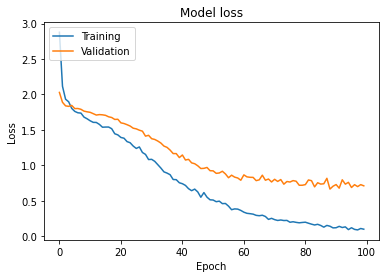

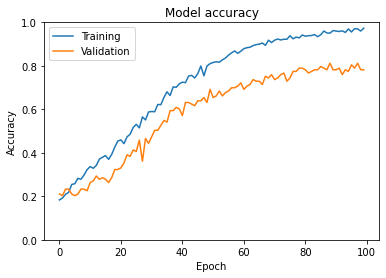

In [4]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.ylim(0, 1)
plt.show()

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
model.evaluate(val_generator)
predict = model.predict(test_generator)
prediction = np.argmax(predict, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, prediction))

7/7 [==============================] - 2s 282ms/step - loss: 0.7114 - accuracy: 0.7820
Confusion Matrix
[[ 6  8  6  7  9  8]
 [ 5  9  3  9  8 11]
 [ 5  8  9  7  7  8]
 [10  5  7  8  7  7]
 [ 9  6  6  8  7  9]
 [ 7  5  8 13  8  3]]


In [11]:
print(classification_report(test_generator.classes, prediction, target_names=class_names))

              precision    recall  f1-score   support

       other       0.14      0.14      0.14        44
          20       0.22      0.20      0.21        45
        1000       0.23      0.20      0.22        44
         500       0.15      0.18      0.17        44
         100       0.15      0.16      0.15        45
          50       0.07      0.07      0.07        44

    accuracy                           0.16       266
   macro avg       0.16      0.16      0.16       266
weighted avg       0.16      0.16      0.16       266

